# Idealized experiments with a flowline model 

In [1]:
import numpy as np
import shapely.geometry as shpg
from oggm.core import flowline, massbalance
from oggm import cfg, utils
import matplotlib.pyplot as plt

In [2]:
# Just get some parameters
cfg.initialize_minimal()

2024-01-18 09:08:06: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2024-01-18 09:08:06: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2024-01-18 09:08:06: oggm.cfg: Multiprocessing: using all available processors (N=8)


## Boundary conditions: glacier bed

In [3]:
def dummy_constant_bed(
    hmax=3000., # max elevation of the domain
    hmin=1000., # min elevation of the domain 
    nx=200, # number of grid points from top to bottom
    map_dx=100., # grid resolution in meters
    widths=3. # Glacier width (in unit map_dx)
):
    """Create a 'glacier bed' for the model"""
    
    dx = 1 # spacing between two grid points (in units map_dx)

    surface_h = np.linspace(hmax, hmin, nx)
    bed_h = surface_h
    widths = surface_h * 0. + widths
    coords = np.arange(0, nx - 0.5, 1)
    line = shpg.LineString(np.vstack([coords, coords * 0.]).T)
    return [flowline.RectangularBedFlowline(line, dx, map_dx, surface_h,
                                            bed_h, widths)]

# Create the bed
flowlines = dummy_constant_bed()

## Mass balance model 

We create a mass-balance profile for the simulations. Linear change with altitude, with option to add mass at any selected grid points.

In [4]:
class AvalancheMassBalance(massbalance.MassBalanceModel):
    """Constant mass balance as a linear function of altitude,
    but with some avalanche at given locations.

    Attributes
    ----------
    ela_h: float
        the equilibrium line altitude (units: [m])
    grad: float
        the mass balance gradient (unit: [mm w.e. yr-1 m-1])
    max_mb: float
        Cap the mass balance to a certain value (unit: [mm w.e. yr-1])
    avalanche_ids : list
        Location of the avalanches, starting from 0 (at the top) until the size of the domain (nx-1)
    avalanche_values : list
        SMB added by the avalanches, in units [mm w.e. yr-1]
    """

    def __init__(self, ela_h, grad=3., max_mb=None,
                 avalanche_ids=[],
                 avalanche_smb=[],
                ):
        """ Initialize.

        Parameters
        ----------
        ela_h: float
            Equilibrium line altitude (units: [m])
        grad: float
            Mass balance gradient (unit: [mm w.e. yr-1 m-1])
        max_mb: float
            Cap the mass balance to a certain value (unit: [mm w.e. yr-1])
        """
        super(AvalancheMassBalance, self).__init__()
        self.hemisphere = 'nh'
        self.valid_bounds = [-1e4, 2e4]  # in m
        self.orig_ela_h = ela_h
        self.ela_h = ela_h
        self.grad = grad
        self.max_mb = max_mb
        
        self.avalanche_ids = avalanche_ids
        self.avalanche_smb = avalanche_smb

    def get_annual_mb(self, heights, year=None, **kwargs):      
        
        # Here we can assume that heights will be the size of the domain - allways
        # Height changes from year to year as the glacier grows
        mb = (np.asarray(heights) - self.ela_h) * self.grad
        
        # Here year is ignored, but it would be easy to use "year" to 
        # take decisions on the massbalance, for example by applying
        # avalanches only after a certain year, or by changing the ELA
        # with time
        # if year > 500: ... etc
        
        # We clip MB to max for a more realistic profile
        if self.max_mb is not None:
            utils.clip_max(mb, self.max_mb, out=mb)
            
        # If there are avalances, add them
        mb[self.avalanche_ids] += self.avalanche_smb
            
        # Convert to units of dynamical model (meters of ice per second)
        return mb / cfg.SEC_IN_YEAR / self.rho

    def is_year_valid(self, year):
        # Thats just needed by the model, don't worry about it
        return True

Let's just check how our SMB profile looks like:

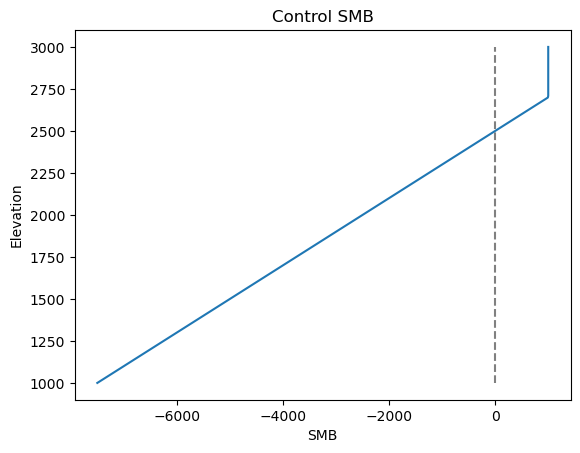

In [5]:
height = flowlines[0].surface_h.copy()  # get the elevation of the bed at time 0

# Create the model
mb_model_control = AvalancheMassBalance(ela_h=2500, max_mb=1000, grad=5)

# Compute the MB and convert back to mm w.e. per year for convenience
smb_control = mb_model_control.get_annual_mb(height) * cfg.SEC_IN_YEAR * mb_model_control.rho

# Plot it
plt.vlines([0], ymin=1000, ymax=3000, linestyles='--', color='grey');
plt.plot(smb_control, height); 
plt.ylabel('Elevation'); plt.xlabel('SMB'); plt.title('Control SMB');

## Run the model: control simulation

In [11]:
model = flowline.SemiImplicitModel(flowlines, 
                                   mb_model=mb_model_control, 
                                   fs=5.7e-20,  # just make ice flow a bit faster - you can try to put 0 here
                                  )

# Two outputs: glacier wide, and along the flowlines
ds_avg_control, ds_fl = model.run_until_and_store(800, fl_diag_path=True)

# We have only one flowline
ds_fl_control = ds_fl[0]

### Glacier wide diagnostics 

In [12]:
ds_avg_control

<xarray.Dataset>
Dimensions:           (time: 801)
Coordinates:
  * time              (time) float64 0.0 1.0 2.0 3.0 ... 797.0 798.0 799.0 800.0
    calendar_year     (time) int64 0 1 2 3 4 5 6 ... 794 795 796 797 798 799 800
    calendar_month    (time) int64 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
    hydro_year        (time) int64 0 1 2 3 4 5 6 ... 794 795 796 797 798 799 800
    hydro_month       (time) int64 4 4 4 4 4 4 4 4 4 4 4 ... 4 4 4 4 4 4 4 4 4 4
Data variables:
    volume_m3         (time) float64 0.0 1.343e+06 ... 4.01e+08 4.01e+08
    volume_bsl_m3     (time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    volume_bwl_m3     (time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    area_m2           (time) float64 0.0 1.5e+06 1.5e+06 ... 3.24e+06 3.24e+06
    length_m          (time) float64 0.0 5e+03 5e+03 ... 1.08e+04 1.08e+04
    calving_m3        (time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    calving_rate_myr  (time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes: (12/14)
    description:          OGGM model output
    oggm_version:         1.6.1.dev38+ge8935b6
    calendar:             365-day no leap
    creation_date:        2024-01-18 08:15:53
    water_level:          0
    glen_a:               2.4e-24
    ...                   ...
    mb_model_hemisphere:  nh
    mb_model_rho:         900.0
    mb_model_orig_ela_h:  2500
    mb_model_ela_h:       2500
    mb_model_grad:        5
    mb_model_max_mb:      1000

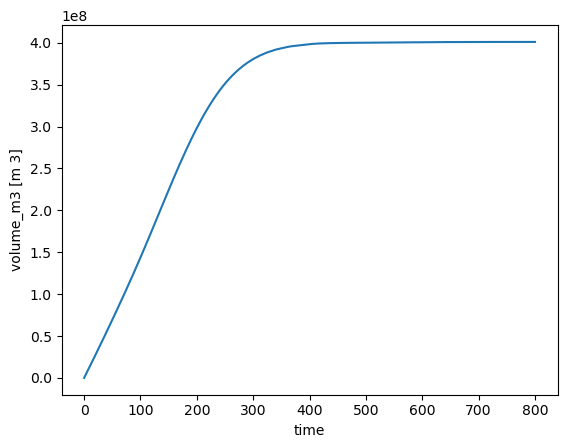

In [13]:
ds_avg_control.volume_m3.plot();

### Flowline diagnostics 

In [14]:
ds_fl_control

<xarray.Dataset>
Dimensions:              (dis_along_flowline: 200, time: 801)
Coordinates:
  * dis_along_flowline   (dis_along_flowline) float64 0.0 100.0 ... 1.99e+04
  * time                 (time) float64 0.0 1.0 2.0 3.0 ... 798.0 799.0 800.0
Data variables:
    bed_h                (dis_along_flowline) float64 3e+03 2.99e+03 ... 1e+03
    volume_m3            (time, dis_along_flowline) float64 0.0 0.0 ... 0.0 0.0
    volume_bsl_m3        (time, dis_along_flowline) float64 0.0 0.0 ... 0.0 0.0
    volume_bwl_m3        (time, dis_along_flowline) float64 0.0 0.0 ... 0.0 0.0
    area_m2              (time, dis_along_flowline) float64 0.0 0.0 ... 0.0 0.0
    thickness_m          (time, dis_along_flowline) float64 0.0 0.0 ... 0.0 0.0
    ice_velocity_myr     (time, dis_along_flowline) float64 nan nan ... 0.0 0.0
    calving_bucket_m3    (time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    flux_divergence_myr  (time, dis_along_flowline) float64 nan nan ... 0.0 0.0
    climatic_mb_myr      (time, dis_along_flowline) float64 nan nan ... 0.0 0.0
    dhdt_myr             (time, dis_along_flowline) float64 nan nan ... 0.0 0.0
Attributes: (12/17)
    class:                TrapezoidalBedFlowline
    map_dx:               100.0
    dx:                   1
    description:          OGGM model output
    oggm_version:         1.6.1.dev38+ge8935b6
    calendar:             365-day no leap
    ...                   ...
    mb_model_hemisphere:  nh
    mb_model_rho:         900.0
    mb_model_orig_ela_h:  2500
    mb_model_ela_h:       2500
    mb_model_grad:        5
    mb_model_max_mb:      1000

#### At a given time 

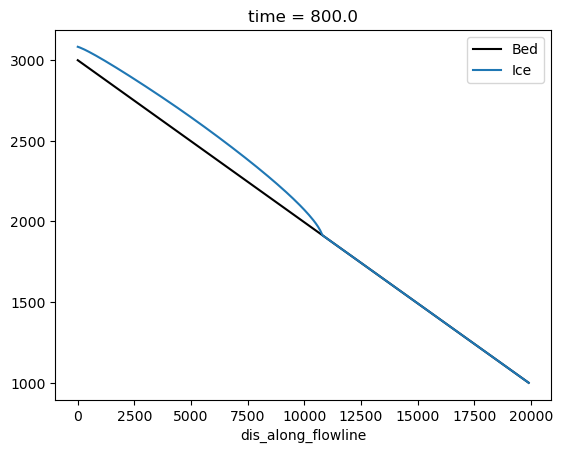

In [17]:
ds_sel_control = ds_fl_control.sel(time=800) 

ds_fl_control.bed_h.plot(color='k', label='Bed');
(ds_sel_control.bed_h + ds_sel_control.thickness_m).plot(label='Ice');
plt.legend();

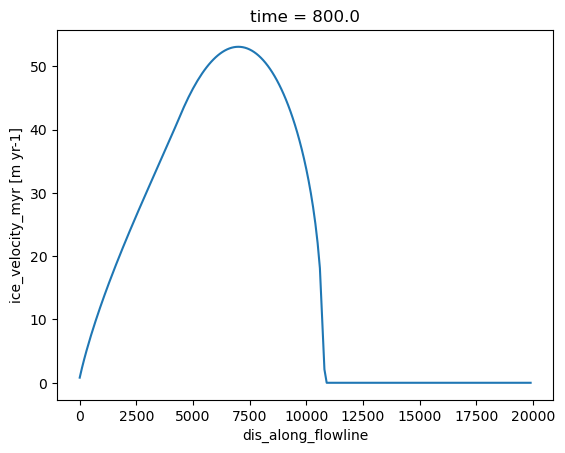

In [18]:
ds_sel_control.ice_velocity_myr.plot();

#### Over time 

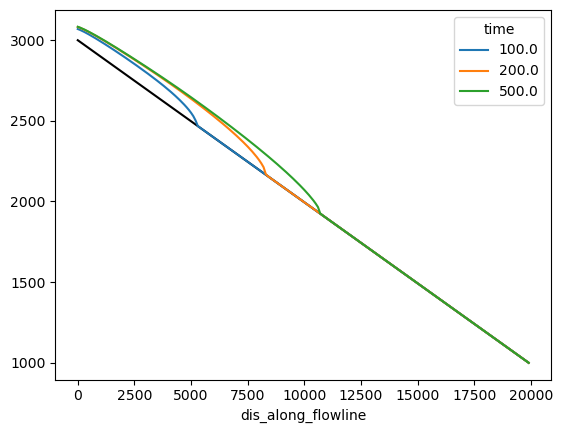

In [19]:
ds_fl_control.bed_h.plot(color='k');
(ds_fl_control.bed_h + ds_fl_control.thickness_m.sel(time=[100, 200, 500])).plot(hue='time');

## Experiment with avalanches 

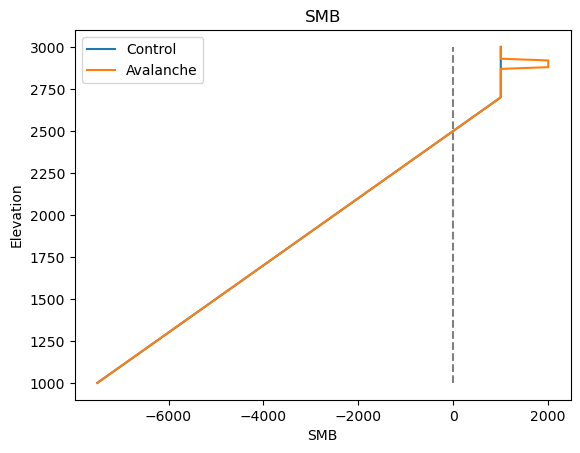

In [20]:
# We create a model with avalanches this time
mb_model_ava = AvalancheMassBalance(ela_h=2500, max_mb=1000, grad=5, 
                                    avalanche_ids=[8, 9, 10, 11, 12], 
                                    avalanche_smb=[1000]*5)

# Same as above
smb_ava = mb_model_ava.get_annual_mb(height) * cfg.SEC_IN_YEAR * mb_model_ava.rho

# Plot it
plt.vlines([0], ymin=1000, ymax=3000, linestyles='--', color='grey');
plt.plot(smb_control, height, label='Control'); 
plt.plot(smb_ava, height, label='Avalanche'); 
plt.ylabel('Elevation'); plt.xlabel('SMB'); plt.title('SMB'); plt.legend();

In [21]:
# Same as above, run the model
model = flowline.SemiImplicitModel(flowlines, 
                                   mb_model=mb_model_ava, 
                                   fs=5.7e-20)
ds_avg_ava, ds_fl = model.run_until_and_store(800, fl_diag_path=True)
ds_fl_ava = ds_fl[0]

### Differences in volume evolution 

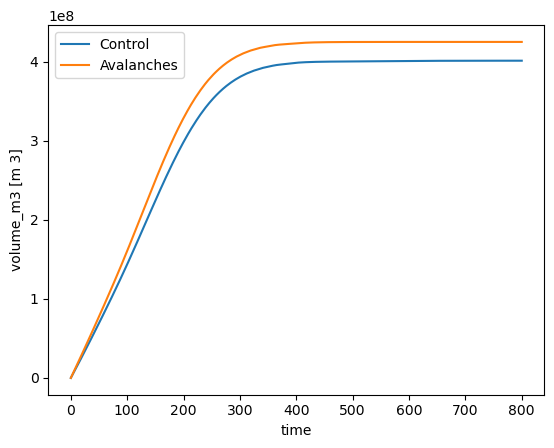

In [15]:
ds_avg_control.volume_m3.plot(label='Control');
ds_avg_ava.volume_m3.plot(label='Avalanches');
plt.legend();

### Differences in geometry and velocity at the end of the simulation 

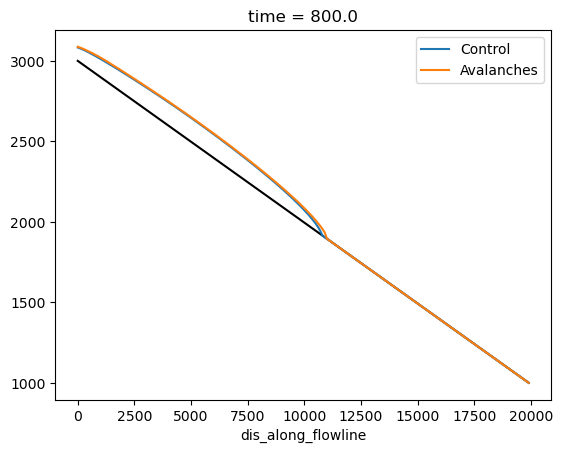

In [16]:
ds_sel_ava = ds_fl_ava.isel(time=-1) 

ds_sel_control.bed_h.plot(color='k');
(ds_sel_control.bed_h + ds_sel_control.thickness_m).plot(label='Control');
(ds_sel_ava.bed_h + ds_sel_ava.thickness_m).plot(label='Avalanches');
plt.legend();

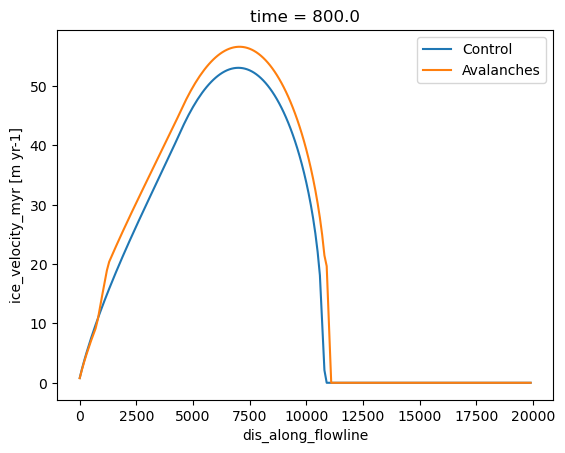

In [17]:
ds_sel_control.ice_velocity_myr.plot(label='Control');
ds_sel_ava.ice_velocity_myr.plot(label='Avalanches');
plt.legend();

## Ideas for experiments

- play with other locations / values for avalanches
- play with other bed geometries / sliding parameters
- probably most important: create a control model and an avalanche model with the same SMB summed over a given region of the domain. In practice we will have an observation of SMB, but no ideas about the MB profile - avalanches therefore wont change the SMB totals but the SMB profile.
- ...